# ICS 438 Final Project
## Sentiment Analysis to Find a Correlation Between Reddit Comments and DIS Stock Prices

# Link to dash board app

### Infrastructure Analysis

#### Docker:
The Docker image creates a Docker container that runs the application and jupyter notebook at the same time. There is no software limit to the number of containers that can be run at the same time.
The container is built on a slim-python build and the necessary python packages. All of these required files are loaded automatically into the container by the image.

#### Data Collection:
PMAW and yfinance API for data collection. PMAW (developed by Matthew Podolak) uses multithreading to improve performance over other popular Reddit scraping API’s and is currently one of the best available open-source API’s for obtaining large amounts of Reddit data. Despite this, pulling millions of samples will require hours on a smaller machine. If scaling up, it would be best to split calls across multiple machines. Data would also be hosted on a cloud service instead of to local machines. Yahoo Finance datasets are small, even for companies with data spanning several decades. The majority of the data comes from Reddit, so pulling Yahoo Finance data that corresponds to the Reddit data should not be an issue to consider when scaling up.

#### Data Analysis:
The libraries used for data processing and analysis include: pandas, NumPy, SciPy, and scikit-learn. Our current code is not optimized for “Big Data” (millions of samples). Our raw dataset is large, but much of it was cleaned up and condensed into smaller dataframes that could be handled in memory. If we were to scale up, we would shift from pandas to PySpark, RDDs instead of pandas dataframes, and a cluster of machines. Reddit data would still be condensed as much as possible, but it would be handled either in chunks or line-by-line to avoid overloading memory.

#### Machine Learning:
The sentiment analysis was conducted by primarily using PyTorch, Hugging Face, Beautiful Soup. Again, the main changes would be to further chunk the data and use PySpark RDDs as opposed to pandas dataframes.

#### Data Visualization:
The libraries used for data visualization include Matplotlib, Plotly, and ASAP. For smaller datasets that did not suffer from cramped visuals, we were able to use Matplotlib alone. For visualization of larger datasets, we used ASAP (developed by Stanford InfoLab) to smoothen plots and better reveal trends in data. The dashboard app was built using Plotly to host/project our visuals. If scaling up, the current tools and code used for data visualizations should be fine.


## Data Gathering - Reddit

This section of code is used to gather reddit data. PMAW is used, and can be found at [https://github.com/mattpodolak/pmaw ](https://github.com/mattpodolak/pmaw ).

```python
from pmaw import PushshiftAPI
````
#### Pulling Reddit posts

```python
api = PushshiftAPI()

all_submissions = api.search_submissions(subreddit="disney", limit=None)
all_sub_df = pd.DataFrame(all_submissions)
all_sub_df.to_csv('./data/disney_all_subs.csv', header=True, index=False, columns=list(all_sub_df.axes[1]))
````
#### Pulling Reddit comments

```python
comments = api.search_comments(subreddit="disney", limit=None)
comments_df = pd.DataFrame(comments)
comments_df.to_csv('./data/disney_comments.csv', header=True, index=False, columns=list(comments_df.axes[1]))
````

## Data Gathering - Finance

This section of code is used to gather stock price data. For this, yfinance is used, info for which can be found at [https://pypi.org/project/yfinance/](https://pypi.org/project/yfinance/).

```python
!pip install yfinance

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

def getFinanceData(stock_name, output_file, start_date, end_date):
  # get stock prices
  msft = yf.Ticker(stock_name)
  hist = msft.history(period="max")
  data = yf.download(stock_name, start=start_date, end=end_date)
  # write output csv
  data.to_csv(output_file, header=True, index=False, columns=list(data.axes[1]))
  return data

````

#### Example code
```python
stock_name = 'DIS'
output_file = 'raw_disney_finance.csv'
start_date = '2000-01-01'
end_date = '2021-11-15'

raw_finance_df = getFinanceData(stock_name, output_file, start_date, end_date)
plt.plot(data.index, raw_finance_df['Close'])
````

## Raw Data:

https://drive.google.com/drive/folders/1jhhzseiX2Qi78ElHTuxlTIhRogJp4CAS?usp=sharing

## Preliminary analysis of Reddit posts

The goal of our project is to predict future Disney (DIS) stock prices based on historical reddit post sentiment analysis and stock prices. Reddit data is separated into two parts: Reddit posts and their associated comments.

Our sentiment analysis was performed on the comments of posts because comments better capture user reactions to a post topic.

Before jumping into the sentiment analysis of comments, we performed linear regressions of DIS stock prices as a function of Reddit post scores and the number of comments associated with each post. We did this for our preliminary analysis because reddit posts are a smaller dataset than their associated comments and we wanted an initial impression of whether or not Reddit post metrics had any correlation with company stock prices.

In [48]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from scipy.stats import linregress

In [49]:
dis_yfinance = pd.read_csv("sampleData/disney_yfinance.csv")
dis_submissions = pd.read_csv("sampleData/disney_all_subs.csv")
disland_submissions = pd.read_csv("sampleData/disneyland_all_subs.csv")
displus_submissions = pd.read_csv("sampleData/disneyplus_all_subs.csv")
pixar_submissions = pd.read_csv("sampleData/pixar_all_subs.csv")

/Users/keeks/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning:

Columns (0,1,4,5,6,8,9,10,11,12,16,18,19,20,21,22,24,25,26,27,28,29,30,31,35,37,39,43,44,49,53,56,58,59,60,65,66,67,68,69,74,75,76,77,78,79,80,81,83,85,87,88,89,90,91,92,93,94,95) have mixed types.Specify dtype option on import or set low_memory=False.

/Users/keeks/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning:

Columns (0,1,4,6,8,9,10,11,12,16,18,19,20,21,22,23,25,26,28,29,31,32,33,34,35,39,41,43,47,48,49,53,57,60,61,63,64,67,68,69,70,71,76,77,79,80,81,82,83,84,87,89,90,91,92,93,94,95,100,101) have mixed types.Specify dtype option on import or set low_memory=False.

/Users/keeks/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3172: DtypeWarning:

Columns (1,9,41,55,66,72,78,80,81,82,83,84,85,88,92,94,95,96) have mixed types.Specify dtype option on import or set low_memory=False.

/Users/keeks/opt/anacon

In [50]:
sub_list = [disland_submissions, displus_submissions, pixar_submissions]

In [51]:
dis_yfinance.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/3/2000,28.855125,29.533344,28.361876,29.471687,23.115255,8402230
1,1/4/2000,29.594999,31.444689,29.594999,31.198063,24.469284,16051191
2,1/5/2000,31.198063,32.677814,31.198063,32.492844,25.484806,19823822
3,1/6/2000,32.492844,32.677814,31.198063,31.198063,24.469284,7903193
4,1/7/2000,31.198063,31.691313,30.396530,30.704813,24.082420,6773543


In [52]:
dis_submissions.head()

,all_awardings,allow_live_comments,author,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_type,author_fullname,author_patreon_flair,author_premium,...,brand_safe,rte_mode,author_id,previous_visits,suggested_sort,author_created_utc,approved_at_utc,banned_at_utc,view_count,creation_date
0,[],False,The-Remix-God-ALT,0,[],0,text,t2_8b0yo2pg,False,False,...,0,0,0,0,0,0.0,0,0,0,01-10-2021
1,[],False,Supershlee777,0,[],0,text,t2_7zle95u7,False,False,...,0,0,0,0,0,0.0,0,0,0,01-10-2021
2,[],False,theagileartist,0,[],0,text,t2_7ohoma2p,False,False,...,0,0,0,0,0,0.0,0,0,0,01-10-2021
3,[],False,PeachyLeee,0,[],0,text,t2_684v8y3b,False,False,...,0,0,0,0,0,0.0,0,0,0,01-10-2021
4,[],False,artsychimichanga,0,[],0,text,t2_50qxngv9,False,False,...,0,0,0,0,0,0.0,0,0,0,01-10-2021


## Append parsed date columns to subreddit and stock datasets

Raw Reddit data stores post dates in utc. Here, we append a readable parsed date column to the loaded dataset and stock dataset so that they have matching date formats.

### Function to append a readable creation date column to subreddit df

In [53]:
dis_submissions['created_utc']

0        1610296640
1        1610295828
2        1610294416
3        1610293394
4        1610292454
            ...    
80255    1417798928
80256    1417798765
80257    1417795991
80258    1417790770
80259    1417789646
Name: created_utc, Length: 80260, dtype: int64

In [54]:
def create_date_reddit(reddit_df):
    sub_dates = []

    for _ in reddit_df['created_utc']:
        fts = datetime.utcfromtimestamp(_).strftime('%m-%d-%Y')
        sub_dates.append(fts)

    # Appends new column to dataframe, contains readable string date-times
    reddit_df['creation_date'] = sub_dates
    
    return(1)

In [55]:
create_date_reddit(dis_submissions)

1

In [56]:
for _ in sub_list:
    create_date_reddit(_)

In [57]:
dis_submissions['creation_date']

0        01-10-2021
1        01-10-2021
2        01-10-2021
3        01-10-2021
4        01-10-2021
            ...    
80255    12-05-2014
80256    12-05-2014
80257    12-05-2014
80258    12-05-2014
80259    12-05-2014
Name: creation_date, Length: 80260, dtype: object

### Function to append parsed dates columns for yfinance df

In [58]:
def yfi_parsed_dates(df):
    parsed_dates = []

    for _ in df['Date']:
        if '-' in _:
            y_datetime_object = datetime.strptime(_, '%Y-%m-%d')
            
        elif '/' in _:
            y_datetime_object = datetime.strptime(_, '%m/%d/%Y')
    
        parsed_dates.append(y_datetime_object)
    
    df['parsed_dates'] = parsed_dates

In [59]:
yfi_parsed_dates(dis_yfinance)

In [60]:
disland_yfinance = dis_yfinance.copy()
displus_yfinance = dis_yfinance.copy()
dispix_yfinance = dis_yfinance.copy()

In [61]:
dis_yfinance.head()

,Date,Open,High,Low,Close,Adj Close,Volume,parsed_dates
0,1/3/2000,28.855125,29.533344,28.361876,29.471687,23.115255,8402230,2000-01-03
1,1/4/2000,29.594999,31.444689,29.594999,31.198063,24.469284,16051191,2000-01-04
2,1/5/2000,31.198063,32.677814,31.198063,32.492844,25.484806,19823822,2000-01-05
3,1/6/2000,32.492844,32.677814,31.198063,31.198063,24.469284,7903193,2000-01-06
4,1/7/2000,31.198063,31.691313,30.396530,30.704813,24.082420,6773543,2000-01-07


### Function to append parsed dates column for subreddit dfs

In [62]:
def red_parsed_dates(df):
    parsed_dates = []
    for _ in df['creation_date']:
        red_datetime_object = datetime.strptime(_, '%m-%d-%Y')
        parsed_dates.append(red_datetime_object)
    df['parsed_dates'] = parsed_dates
    
    return(1)

In [63]:
red_parsed_dates(dis_submissions)

1

In [64]:
for _ in sub_list:
    red_parsed_dates(_)

## Match date ranges of yfinance and subreddit posts

For our linear regression we want stock prices and Reddit post values of the same dates.

In [65]:
dis_submissions['parsed_dates'].sort_values()

80259   2014-12-05
80258   2014-12-05
80248   2014-12-05
80250   2014-12-05
80251   2014-12-05
           ...    
904     2021-12-04
903     2021-12-04
902     2021-12-04
901     2021-12-04
900     2021-12-04
Name: parsed_dates, Length: 80260, dtype: datetime64[ns]

In [66]:
dis_yfinance['parsed_dates']

0      2000-01-03
1      2000-01-04
2      2000-01-05
3      2000-01-06
4      2000-01-07
          ...    
5488   2021-10-25
5489   2021-10-26
5490   2021-10-27
5491   2021-10-28
5492   2021-10-29
Name: parsed_dates, Length: 5493, dtype: datetime64[ns]

In [67]:
def match_date_range(yfinance_df, reddit_df):

    reddit_begin = reddit_df['parsed_dates'].iloc[-1]
    reddit_end = reddit_df['parsed_dates'].sort_values().iloc[0]
    yahoo_end = yfinance_df['parsed_dates'].iloc[-1]
    
    reddit_df = reddit_df[(reddit_df['parsed_dates'] <= yahoo_end)]
    yfinance_df = yfinance_df[(yfinance_df['parsed_dates'] >= reddit_begin)]

    
    return(yfinance_df, reddit_df)

In [68]:
dis_yfinance = match_date_range(dis_yfinance, dis_submissions)[0]
dis_submissions = match_date_range(dis_yfinance, dis_submissions)[1]

In [69]:
disland_yfinance = match_date_range(disland_yfinance, disland_submissions)[0]
disland_submissions = match_date_range(disland_yfinance, disland_submissions)[1]

displus_yfinance = match_date_range(displus_yfinance, displus_submissions)[0]
displus_submissions = match_date_range(displus_yfinance, displus_submissions)[1]

dispix_yfinance = match_date_range(dispix_yfinance, pixar_submissions)[0]
pixar_submissions = match_date_range(dispix_yfinance, pixar_submissions)[1]

In [70]:
dis_submissions['parsed_dates'].sort_values()

80259   2014-12-05
80248   2014-12-05
80249   2014-12-05
80250   2014-12-05
80251   2014-12-05
           ...    
813     2021-10-29
812     2021-10-29
811     2021-10-29
821     2021-10-29
800     2021-10-29
Name: parsed_dates, Length: 78872, dtype: datetime64[ns]

In [71]:
dis_yfinance['parsed_dates']

3755   2014-12-05
3756   2014-12-08
3757   2014-12-09
3758   2014-12-10
3759   2014-12-11
          ...    
5488   2021-10-25
5489   2021-10-26
5490   2021-10-27
5491   2021-10-28
5492   2021-10-29
Name: parsed_dates, Length: 1738, dtype: datetime64[ns]

## Group together desired values with same dates in subreddit df

There is a single closing stock price every business day, but many subreddit posts are possible on any given day. Here we group together subreddit post values of the same date.

In [72]:
def group_by_date(df):
    reddit_sub_scores = df[['num_comments', 'score', 'parsed_dates']]
    scores_date_grouped = reddit_sub_scores.groupby(reddit_sub_scores['parsed_dates'].dt.date, as_index=True).sum()
    scores_date_grouped['parsed_dates'] = scores_date_grouped.index
    scores_date_grouped_df = scores_date_grouped.set_index(np.arange(len(scores_date_grouped)))
    
    return(scores_date_grouped_df)

In [73]:
scores_date_grouped_df = group_by_date(dis_submissions)
scores_date_grouped_df

,num_comments,score,parsed_dates
0,20,300,2014-12-05
1,62,448,2014-12-06
2,36,135,2014-12-07
3,62,577,2014-12-08
4,76,768,2014-12-09
...,...,...,...
2498,44,51,2021-10-25
2499,15,40,2021-10-26
2500,145,56,2021-10-27
2501,32,45,2021-10-28


In [74]:
land_scores_date_grouped_df = group_by_date(disland_submissions)
plus_scores_date_grouped_df = group_by_date(displus_submissions)
pixar_scores_date_grouped_df = group_by_date(pixar_submissions)

### Function to add weekend reddit values to mondays, then drop weekend values from subreddit df

The stock market is only open on business days, but there are reddit posts every day. To deal with this, take the sum of the weekend scores and # of comments and add these to Monday. The idea is that news over the weekend affects stock prices the following business day. Then remove weekend values.

In [75]:
def group_weekend_metrics(grouped_df):
    weekends = 0
    weekends_coms = 0
    i = 0
    k = 0
    weekend_dict = {}
    weekend_coms_dict = {}
    weekender = []
    weekender_coms = []
    dict_arr = []

    for _ in np.arange(len(grouped_df)):
        if grouped_df.iloc[_]['parsed_dates'].weekday() !=  5 and grouped_df.iloc[_]['parsed_dates'].weekday() != 6:
            weekend_dict[grouped_df.iloc[_]['parsed_dates']] = 0
            weekend_coms_dict[grouped_df.iloc[_]['parsed_dates']] = 0


    for _ in np.arange(len(grouped_df)):
        
        if grouped_df.iloc[_]['parsed_dates'].weekday() == 5:
            weekends += grouped_df.iloc[_]['score']
            weekends_coms += grouped_df.iloc[_]['num_comments']
            
        if grouped_df.iloc[_]['parsed_dates'].weekday() == 6 and grouped_df.iloc[_ + 1]['parsed_dates'].weekday() == 0:
            weekends += grouped_df.iloc[_]['score']
            weekends_coms += grouped_df.iloc[_]['num_comments']
            weekender.append(weekends)
            weekender_coms.append(weekends_coms)

        if grouped_df.iloc[_]['parsed_dates'].weekday() == 0 and grouped_df.iloc[_ - 1]['parsed_dates'].weekday() == 6:
            monday = grouped_df.iloc[_]['score'] + 1
            monday_coms = grouped_df.iloc[_]['num_comments'] + weekender_coms[i]

            grouped_df.loc[grouped_df.index[_], 'score'] = monday
            grouped_df.loc[grouped_df.index[_], 'num_comments'] = monday_coms
            i += 1

            weekends = 0
            weekends_coms = 0

        if grouped_df.iloc[_]['parsed_dates'].weekday() !=  5 and grouped_df.iloc[_]['parsed_dates'].weekday() != 6:
            weekend_dict[grouped_df.iloc[_]['parsed_dates']] = (grouped_df.iloc[_]['score'])
            weekend_coms_dict[grouped_df.iloc[_]['parsed_dates']] = (grouped_df.iloc[_]['num_comments'])
            
            
            dict_arr.append(weekend_dict)
            dict_arr.append(weekend_coms_dict)
            
    df = pd.DataFrame(np.arange(len(weekend_dict)))
    df['parsed_dates'] = weekend_dict.keys()
    df['score'] = weekend_dict.values()
    df['num_comments'] = weekend_coms_dict.values()
    df.drop(columns=0, inplace=True)
        
    return df

In [76]:
weekday_df = group_weekend_metrics(scores_date_grouped_df)
weekday_df.head()

,parsed_dates,score,num_comments
0,2014-12-05,300,20
1,2014-12-08,578,160
2,2014-12-09,768,76
3,2014-12-10,1105,143
4,2014-12-11,392,49


In [77]:
land_df = group_weekend_metrics(land_scores_date_grouped_df)
plus_df = group_weekend_metrics(plus_scores_date_grouped_df)
pixar_df = group_weekend_metrics(pixar_scores_date_grouped_df)

In [78]:
len(weekday_df) == len(dis_yfinance)

False

## Function to remove remaining unmatched days (Holidays and other non-business days)

Remaining unmatched days are likely holidays, days that the stock market unexpectedly closed, and days without subreddit posts.

In [79]:
def match_dates(yfinance_df, reddit_df):
    yfi_dates = list(yfinance_df['parsed_dates'])
    reddit_dates = list(reddit_df['parsed_dates'])

    drop_it_red = []
    drop_it_yfi = []

    i = 0
    k = 0

    for _ in np.arange(len(reddit_df)):
        if reddit_df.iloc[_]['parsed_dates'] not in yfi_dates:
            drop_it_red.append(i)
        i += 1

    reddit_df.drop(reddit_df.index[drop_it_red], inplace=True)

    for _ in np.arange(len(yfinance_df)):
        if yfinance_df.iloc[_]['parsed_dates'] not in reddit_dates:
            drop_it_yfi.append(k)
        k += 1

    yfinance_df.drop(yfinance_df.index[drop_it_yfi], inplace=True)
    
    return(1)

In [80]:
match_dates(dis_yfinance, weekday_df)

1

In [81]:
match_dates(disland_yfinance, land_df)
match_dates(displus_yfinance, plus_df)
match_dates(dispix_yfinance, pixar_df)

1

In [82]:
assert len(weekday_df) == len(dis_yfinance)

## Map of DisneyLand Ride Sentiments

In [83]:
# Tab 2: Disneyland Ride Sentiments

from sklearn import preprocessing
import folium
import branca
import branca.colormap as cm

df_rides = pd.read_csv("./sampleData/disneyland_rides_lat_long_w_sentiment.csv")

#create a map object
map = folium.Map(location=[33.8121, -117.9190], zoom_start=18)

loc = 'Reddit sentiments shown by ride location, normalized between 0 and 1'
title_html = '''
             <h3 align="center" style="font-size:32px;font-family:Avenir"><b>{}</b></h3>
             '''.format(loc) 
map.get_root().html.add_child(folium.Element(title_html))

#create a feature group
fg = folium.FeatureGroup(name="Disneyland Attractions")

#read in the data
# data = pd.read_csv("disneyland_attractions.csv")
data = df_rides

colormap = cm.LinearColormap(
    colors=['red','green'],
    index=[0,1],vmin=0,vmax=1
)

#iterate through the dataframe and add each attraction to the feature group
for index, row in data.iterrows():
    fg.add_child(folium.Marker(
        location=[row["lat"], row["long"]], 
        popup="{} : {}".format(row["ride"].upper(), round(row['sentiment'], 2)), 
        icon=folium.Icon(color="black", icon_color=colormap(row['sentiment'])))
    )

map.add_child(colormap)
    
#add the feature group to the map
map.add_child(fg)

ride_map = map.save('ride_map.html')

## Ticker plot of Dis prices from 12/05/2014 to 12/05/2021

In [84]:
# Dash and extra Plotly modules
import dash
import dash_core_components as dcc
import dash_html_components as html
import dash_bootstrap_components as dbc
import dash_daq as daq
import dash_table as dt
from dash_table.Format import Format, Scheme, Group
from dash.dependencies import Input, Output, State
from dash_bootstrap_templates import load_figure_template

import plotly.io as pio

import plotly.express as px
from plotly.express import data

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# See available templates
# pio.templates

In [85]:
template = 'presentation'

# Graph styles
graph_layout = dict(
    font_family = 'Avenir',
    font_size = 24,
    title_x = 0.5,  
)

## Saving Graphs using Pickle for app.py Dash/Plotly App

In [86]:
import pickle

def save_graph(fig, file_path):
    f = open(file_path, 'wb')
    pickle.dump(fig, f)
    f.close()

In [87]:
stock_prices_fig = px.line(
    dis_yfinance,
    x = 'parsed_dates',
    y = 'Close',
    title = 'Disney (Ticker: DIS) Stock Price vs. Time',
    labels = dict(
        parsed_dates = 'Date (Year)',
        Close = 'Stock Price (USD)'
    ),
    template = template,
)

stock_prices_fig.update_layout(height = 850)
stock_prices_fig.update_layout(graph_layout)

save_graph(stock_prices_fig, 'graphs/stock_prices.txt')

stock_prices_fig.show()

## Methods for Four-Subplot Graph Creation

#### DataFrame Merging

In [88]:
# For replicatability, merge 4 subreddit dataframes into one.
## Use an outer join, keeping the left-most column as the common column.
def outer_join_four_dfs(x, y, left, dfs, names):
    clean_dfs = []
    assert len(dfs) == 4 and len(names) == 4
    for i in range(4):
        clean_dfs.append(outer_join_clean(x, y, left, dfs[i], names[i]))

    m1 = pd.merge(clean_dfs[0], clean_dfs[1], on = left, how = 'outer')
    m2 = pd.merge(m1, clean_dfs[2], on = left, how = 'outer')
    result = pd.merge(m2, clean_dfs[3], on = left, how = 'outer')

    result = result.sort_values(left)
    return result

def outer_join_clean(x, y, left, df, name):
    result = df.filter([x, y])
    result.columns = [left, name]
    return result

# Find the overall mins and maxes to make scales consistent in subplots.
def df_min_max(df, cols):
    min = np.min(df[cols].min(axis = 0))
    max = np.max(df[cols].max(axis = 0))
    return [min, max]

#### Subplot Methods

In [89]:
four_subplot_indices = [[1, 1], [1, 2], [2, 1], [2, 2]]

def scatter_trace(df, left, name):
    return go.Scatter(
        x = df[left],
        y = df[name],
        marker = dict(size = 5),
        mode = 'markers',
    )

def scatter_four_subplots(left, x_key, y_key, title):

    joint_df = outer_join_four_dfs(
        x_key, y_key, left, subreddit_dfs, subreddit_names
    )

    y_range = df_min_max(joint_df, subreddit_names)

    fig = make_subplots(
        subplot_titles = subreddit_names,
        rows = 2, cols = 2
    )

    for subplot, subreddit in zip(four_subplot_indices, subreddit_names):
        fig.add_trace(
            scatter_trace(
                joint_df, left, subreddit,
            ),
            row = subplot[0],
            col = subplot[1]
    )

    fig.update_yaxes(range = y_range)

    fig.update_layout(
        title = title,
        height = 850,
        template = template,
        showlegend = False,
    )

    fig.update_layout(graph_layout)

    return fig


## Plots: Disney subreddit post scores over time

In [90]:
subreddit_dfs = [
    weekday_df,
    land_df,
    plus_df,
    pixar_df
]

subreddit_names = [
    'r/Disney',
    'r/DisneyLand',
    'r/DisneyPlus',
    'r/Pixar'
]

post_scores_fig = scatter_four_subplots(
    'date', 'parsed_dates', 'score',
    'Subreddit Post Score vs. Time'
)

save_graph(post_scores_fig, 'graphs/post_scores.txt')

post_scores_fig.show()

## Plots: # of comments for Disney subreddit posts over time

In [91]:
comments_fig = scatter_four_subplots(
    'date', 'parsed_dates', 'num_comments',
    'Number of Comments on Posts vs. Time'
)

save_graph(comments_fig, 'graphs/comments.txt')

comments_fig.show()

## Linear Regressions: DIS stock prices v. subreddit post scores | # of comments

In [92]:
sub_list = [weekday_df, land_df, plus_df, pixar_df]
disc_list = ["r/disney", "r/DisneyLand", "r/DisneyPlus", "r/Pixar"]
yfi_list = [dis_yfinance, disland_yfinance, displus_yfinance, dispix_yfinance]

In [93]:
X_score_arr = []
X_coms_arr = []
y_arr = []
linreg_score_arr = []
linreg_coms_arr = []

for _ in np.arange(len(sub_list)):
    X_score = sub_list[_]['score']
    X_coms = sub_list[_]['num_comments']
    y = yfi_list[_]['Close']
    
    linreg_score = linregress(sub_list[_]['score'], yfi_list[_]['Close'])
    linreg_coms = linregress(sub_list[_]['num_comments'], yfi_list[_]['Close'])
    
    X_score_arr.append(X_score)
    X_coms_arr.append(X_coms)
    y_arr.append(y)
    linreg_score_arr.append(linreg_score)
    linreg_coms_arr.append(linreg_coms)
    
    print(f"{disc_list[_]}")
    print("-" * len(disc_list[_]))
    print(f"Linear regression of stock prices as function of {disc_list[_]} post scores")
    print(f"The slope is: {linreg_score.slope}")
    print(f"The Interecept is: {linreg_score.intercept}")
    print(f"The p.value is: {linreg_score.pvalue}\n")

    print(f"Linear regression of stock prices as function of number of comments on {disc_list[_]} posts")
    print(f"The slope is: {linreg_coms.slope}")
    print(f"The Interecept is: {linreg_coms.intercept}")
    print(f"The p.value is: {linreg_coms.pvalue}")
    print("---------------------------------------------------------------------------------------------")


r/disney
--------
Linear regression of stock prices as function of r/disney post scores
The slope is: -0.004172330712605526
The Interecept is: 124.25571347906588
The p.value is: 8.777905974278167e-18

Linear regression of stock prices as function of number of comments on r/disney posts
The slope is: -0.0015742122928569875
The Interecept is: 120.54029833002436
The p.value is: 0.7595610808895535
---------------------------------------------------------------------------------------------
r/DisneyLand
------------
Linear regression of stock prices as function of r/DisneyLand post scores
The slope is: 0.007544595483993475
The Interecept is: 104.47771222246878
The p.value is: 1.588053996069696e-13

Linear regression of stock prices as function of number of comments on r/DisneyLand posts
The slope is: 0.05561342720418271
The Interecept is: 94.30581436036616
The p.value is: 7.926890670251497e-113
---------------------------------------------------------------------------------------------
r/D

### DIS stock prices as a function subreddit post scores

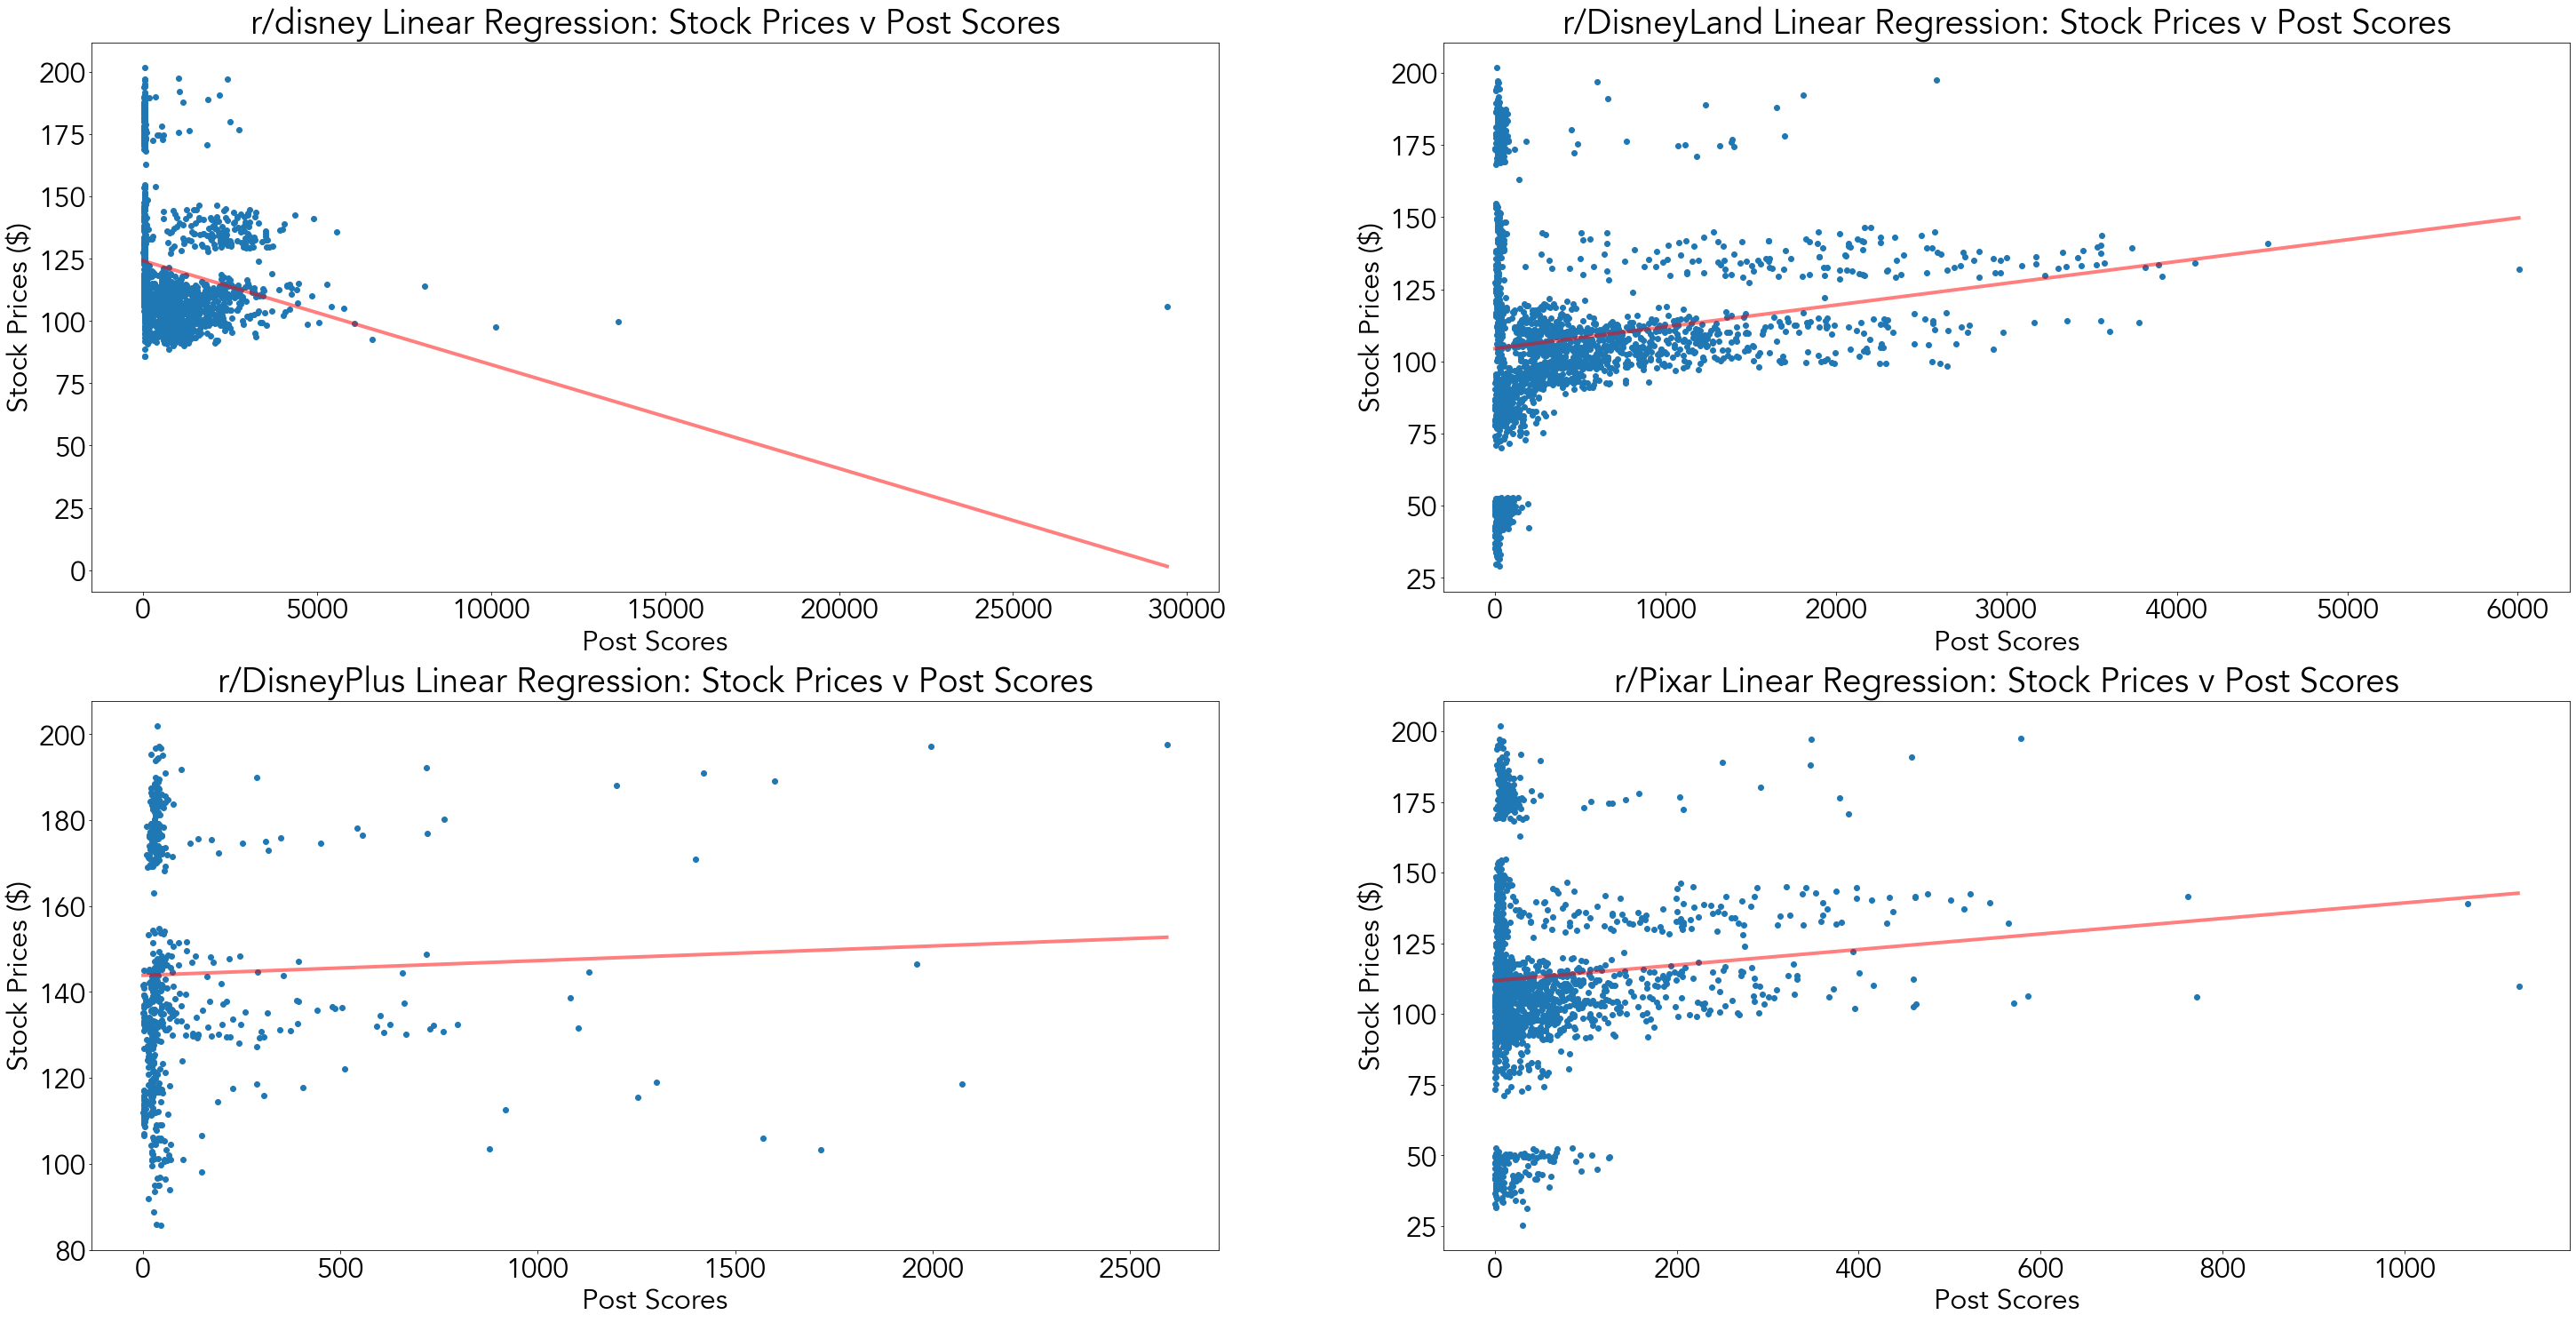

In [94]:
font = dict(
    family = 'Avenir',
    weight = 'bold',
    size = 32
)

matplotlib.rc('font', **font)

fig, axes = plt.subplots(2, 2, figsize=(50, 25))

linreg_plots = [("r/disney", X_score_arr[0], y_arr[0], linreg_score_arr[0]), 
               ("r/DisneyLand", X_score_arr[1], y_arr[1], linreg_score_arr[1]),
               ("r/DisneyPlus", X_score_arr[2], y_arr[2], linreg_score_arr[2]),
               ("r/Pixar", X_score_arr[3], y_arr[3], linreg_score_arr[3])
              ]

for i, ax in enumerate(fig.axes):
    (label, X_score, y, linreg_score) = linreg_plots[i]
    x_axis = np.arange(max(X_score))
    y_line = linreg_score.intercept + linreg_score.slope * x_axis
    
    ax = plt.subplot(2, 2, i+1)
    ax.scatter(X_score, y)
    plt.plot(x_axis, y_line, color='red', linewidth=4, alpha=0.5)
    ax.set_title(label + " Linear Regression: Stock Prices v Post Scores")
    ax.set_xlabel("Post Scores")
    ax.set_ylabel("Stock Prices ($)")

### DIS stock prices as a function subreddit post # of comments

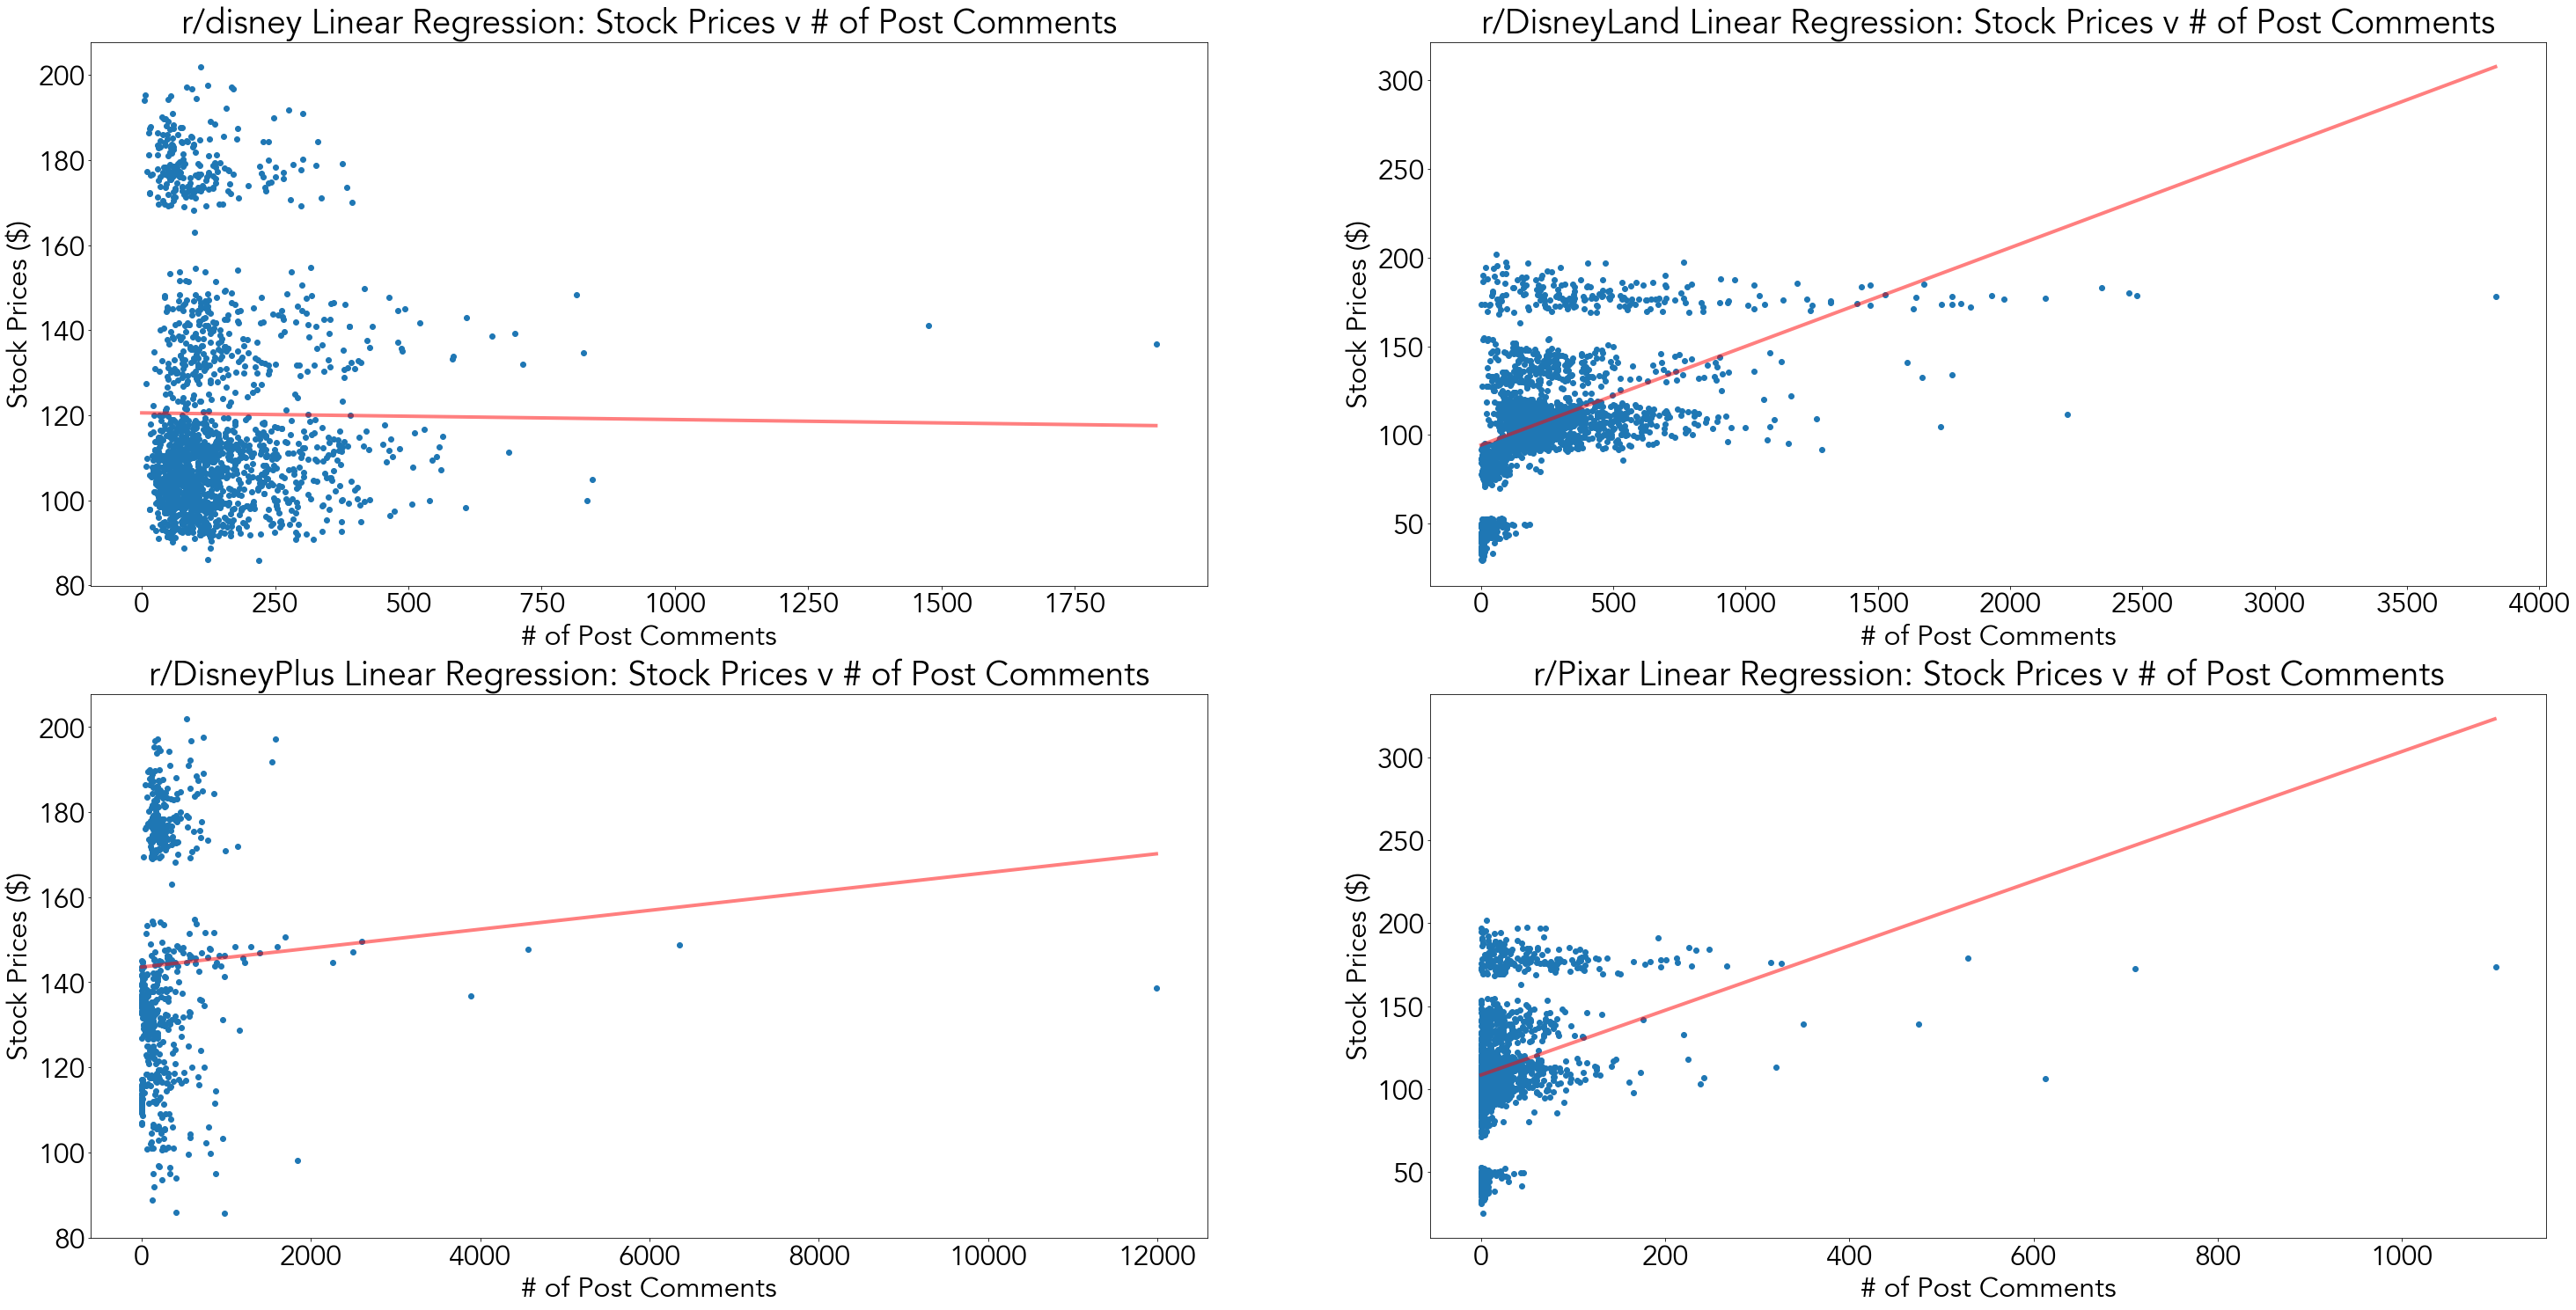

In [95]:
fig, axes = plt.subplots(2, 2, figsize=(50, 25))

linreg_plots = [("r/disney", X_coms_arr[0], y_arr[0], linreg_coms_arr[0]), 
               ("r/DisneyLand", X_coms_arr[1], y_arr[1], linreg_coms_arr[1]),
               ("r/DisneyPlus", X_coms_arr[2], y_arr[2], linreg_coms_arr[2]),
               ("r/Pixar", X_coms_arr[3], y_arr[3], linreg_coms_arr[3])
              ]

for i, ax in enumerate(fig.axes):
    (label, X_coms, y, linreg_coms) = linreg_plots[i]
    x_axis = np.arange(max(X_coms))
    y_line = linreg_coms.intercept + linreg_coms.slope * x_axis
    
    ax = plt.subplot(2, 2, i+1)
    ax.scatter(X_coms, y)
    plt.plot(x_axis, y_line, color='red', linewidth=4, alpha=0.5)
    ax.set_title(label + " Linear Regression: Stock Prices v # of Post Comments")
    ax.set_xlabel("# of Post Comments")
    ax.set_ylabel("Stock Prices ($)")

# Sentiment Analysis Source Code

## 1. Overview

This source code provides a detailed pipeline of cleaning raw Reddit and Stock data, performing sentiment analysis, and graphing the results. While this code should be fairly robust, we recommend running it on Google Colab for best performance (assuming the dataset is small enough to perform).

*There are 6 major steps in this pipeline:*

1. **Data Cleaning:** Once the Reddit data is pulled from the internet, it needs to be cleaned. There are a lot of posts/comments that have been deleted or removed since originally being posted, and some that don't have any content. After these are removed, the creation date is reformatted into a YYYY-MM-DD string format. 

2. **Sentiment Analysis:** After the Reddit data is cleaned, we can perform sentiment analysis on it. Google's BERT sentiment analysis model can be downloaded and used for this step. 

3. **Data Selection for Graphing:** Once the Reddit data is cleaned and passed through the sentiment analysis, we need to compare it to the stock market data. There are holes in the Reddit data since many posts/comments have been deleted or removed since their original upload, and there is no stock market data from weekends or holidays. Thus, we need to find a set of usable dates that both datasets have entries for. This step also removes all unnecessary field from the data to prepare it for graphing.

4. **ASAP Open Source Data Smoothing:** The sentiment data alone is incredibly volatile and messy, so data smoothing is needed. The ASAP model for smoothing data works great, and is applied to the Reddit sentiment data. The source code from this step is the entirety of the open source code fro the ASAP model.

5. **Final Graphing:** This step takes in the data from step 4 and feeds it into step 5, producing a dataset that is ready to be plotted. It returns a dataframe containing the smoothed out data, so it can be exported and plotted in something like Plot.Ly.

In [96]:
# Please run this cell first, as most future code blocks utilize the libraries included below:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

## 2. Data Cleaning

After getting the data, this section of code cleans the data and reduces it to only the usable (graphable) values.

In [97]:
def cleanTimestamps(df):
  '''
  A helper function to remove rows of data with bad dates, 
  then reformat all dates to YYYY-MM-DD string format.
  INPUT: df - dataframe to reformat
  OUTPUT: reformatted dataframe
  '''

  # remove posts with invalid timestamps
  df = df.dropna(subset=['created_utc'])
  null_df = df.created_utc.isnull()
  df = df[null_df == False]
  df = df[df.created_utc != "[deleted]"]
  df = df[df.created_utc != "[removed]"]

  # remove incorrectly formatted timestamps
  rows_to_keep = []
  with tqdm(total=len(df)) as pbar:
    for i in range(len(df)):
      rows_to_keep.append(not isinstance(df.iloc[i].created_utc, str))
      pbar.update(1)
  df = df[rows_to_keep]

  # create formatted timestamps
  sub_dates = []
  for time in df['created_utc']:
    fts = datetime.utcfromtimestamp(time).strftime('%Y-%m-%d')
    sub_dates.append(fts)

  # append new timestamps
  df['Date'] = sub_dates
  df = df.sort_values(by=['Date'])

  return df

In [98]:
def cleanRedditPosts(input_file, output_file, input_df=None, use_df=False):
  '''
  A function that cleans reddit post data, removing bad entries and 
  fixing the date fields.
  INTPUT: input_file  - string name of data file
          output_file - string name of file to write to
          input_df    - input database, replaces input_file
          use_df      - boolean indicating whether or not to use input_df instead of input_file
  OUTPUT: dataframe containing cleaned reddit posts
  '''

  # get input data
  if input_file and not use_df:
    posts_df = pd.read_csv(input_file)
  else:
    posts_df = input_df.copy()

  # remove invalid posts
  null_posts_df = posts_df.selftext.isnull()
  posts_df = posts_df[null_posts_df == False]
  posts_df = posts_df[posts_df.selftext != "[deleted]"]
  posts_df = posts_df[posts_df.selftext != "[removed]"]

  # remove posts whose content is too long
  posts_df = posts_df[posts_df.selftext.apply(lambda x: len(str(x)) < 512)]

  # clean timestamps
  posts_df = cleanTimestamps(posts_df)

  # write output csv
  posts_df.to_csv(output_file, header=True, index=False, columns=list(posts_df.axes[1]))

  return posts_df

In [99]:
def cleanRedditComments(input_file, output_file, input_df=None, use_df=False):
  '''
  A function that cleans reddit comments data, removing bad entries and 
  fixing the date fields.
  INTPUT: input_file  - string name of data file
          output_file - string name of file to write to
          input_df    - input database, replaces input_file
          use_df      - boolean indicating whether or not to use input_df instead of input_file
  OUTPUT: dataframe containing cleaned reddit comments
  '''

  # get input data
  if input_file and not use_df:
    comments_df = pd.read_csv(input_file)
  else:
    comments_df = input_df.copy()

  # remove invalid posts
  null_comments_df = comments_df.body.isnull()
  comments_df = comments_df[null_comments_df == False]
  comments_df = comments_df[comments_df.body != "[deleted]"]
  comments_df = comments_df[comments_df.body != "[removed]"]

  # remove posts whose content is too long
  comments_df = comments_df[comments_df.body.apply(lambda x: len(str(x)) < 512)]

  # clean timestamps
  comments_df = cleanTimestamps(comments_df)

  # write data to csv
  comments_df.to_csv(output_file, header=True, index=False, columns=list(comments_df.axes[1]))

  return comments_df

## 3. Sentiment Analysis

This section of code is used to perform sentiment analysis on the reddit content. Google's BERT (Bidirectional Encoder Representations from Transformers) model is downloaded and used for this process (see research paper for more information: [https://arxiv.org/pdf/1810.04805.pdf](https://arxiv.org/pdf/1810.04805.pdf)).

```python
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html
    
!pip install transformers requests beautifulsoup4 pandas numpy
```

In [100]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re

In [101]:
def getSentiment(input_file, output_file, is_posts, input_df=None, use_df=False):
  '''
  A function that runs reddit content (posts or comments) through a sentiment 
  model, assigning a score from 1 to 5 (bad to good).
  INTPUT: input_file  - string name of data file
          output_file - string name of file to write to
          is_posts    - boolean indicating posts (true) or comments (false)
          input_df    - input database, replaces input_file
          use_df      - boolean indicating whether or not to use input_df instead of input_file
  OUTPUT: dataframe containing data with appended sentiment score
  '''

  # get input data
  if input_file and not use_df:
     df = pd.read_csv(input_file)
  else:
    df = input_df.copy()

  # create new sentiment column
  df['Sentiment'] = ""

  # instantiate model
  tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
  model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

  # perform sentiment analysis
  with tqdm(total=len(df)) as pbar:
    for i in range(len(df)):
      tokens = []
      # analyze post
      if is_posts is True:
        tokens = tokenizer.encode(df.iloc[i].selftext, return_tensors='pt')
      # analyze comment
      else:
        tokens = tokenizer.encode(df.iloc[i].body, return_tensors='pt')
      result = model(tokens)
      # df['Sentiment'].iloc[i] = (int(torch.argmax(result.logits))+1)
      df['Sentiment'].iloc[i] = (int(torch.argmax(result.logits))+1)
      pbar.update(1)

  # write output file
  df.to_csv(output_file, header=True, index=False, columns=list(df.axes[1]))

  return df

## 4. Data Selection for Graphing

This section of code performs final preparations on the data, getting it ready to be graphed. After data cleaning, the number of data points per day is not consistent between datasets, so this code handles that.

In [102]:
from statistics import mean

In [103]:
def averageDailySentiment(df):
  '''
  A helper function that averages the sentiment score for each day.
  INPUT: dataframe to average daily sentiment
  OUTPUT: dataframe with averaged daily sentiment
  '''

  # iterate over data, counting frequency of dates
  sentiment_dict = {}
  for i in range(len(df)):
    key = df.loc[i,'Date']
    value = df.loc[i,'Sentiment']
    # add new dates to dict
    if key not in sentiment_dict:
      sentiment_dict[key] = [value]
    # update count of existing dates
    else:
      sentiment_dict[key].append(value)

  dates=[]
  sentiments=[]

  # create new dataframe with daily average sentiment
  for key in sentiment_dict:
    value = mean([float(x) for x in sentiment_dict[key]])
    value = int(round(value))
    dates.append(key)
    sentiments.append(value)

  df = pd.DataFrame(list(zip(dates, sentiments)), columns=['Date', 'Sentiment'])

  return df

In [104]:
def getDateAndSentiment(input_file, output_file, input_df=None, use_df=False):
  '''
  A function that averages daily sentiment from an entire reddit content database 
  and returns cleaned data of just the plottable fields.
  INTPUT: input_file  - string name of data file
          output_file - string name of file to write to
          input_df    - input database, replaces input_file
          use_df      - boolean indicating whether or not to use input_df instead of input_file
  OUTPUT: dataframe only containing cleaned date and sentiment fields
  '''

  # get input data
  if input_file and not use_df:
    raw_df = pd.read_csv(input_file)
  else:
    raw_df = input_df.copy()
    raw_df.reset_index(drop=True, inplace=True)
  # create new df with just dates and sentiment
  filtered_df = raw_df[['Date', 'Sentiment']].copy()
  # average the daily sentiment
  filtered_df = averageDailySentiment(filtered_df)
  # write output csv
  filtered_df.to_csv(output_file, header=True, index=False, columns=list(filtered_df.axes[1]))
  return filtered_df

In [105]:
def getUsableData(sentiment_input_file, finance_input_file, 
                  sentiment_output_file, finance_output_file, 
                  sentiment_input_df=None, finance_input_df=None,
                  use_sentiment_df=False, use_finance_df=False):
  '''
  A function that takes in the reddit and finance data, 
  outputting graphable overlaps of the data (dates need to line up).
  INPUT:  sentiment_input_file  - string name of sentiment input file
          finance_input_file    - string name of finance input file
          sentiment_output_file - string name of file to output sentiment to
          finance_output_file   - string name of file to output finance to
          sentiment_input_df    - dataframe to override sentiment_input_file
          finance_input_df      - dataframe to override finance_input_file
          use_sentiment_df      - boolean for whether or not sentiment_input_df replaces sentiment_input_file
          use_finance_df        - boolean for whether or not finance_input_df replaces finance_input_file
  OUTPUT: dataframe of graphable sentiment, dataframe of graphable finance
  '''

  # get sentiment input data
  if sentiment_input_file and not use_sentiment_df:
    sentiment_df = pd.read_csv(sentiment_input_file)
  else:
    sentiment_df = sentiment_input_df.copy()
  
  # get finance input data
  if finance_input_file and not use_finance_df:
    finance_df = pd.read_csv(finance_input_file)
  else:
    finance_df = finance_input_df.copy()

  # get list of dates
  sentiment_dates = list(sentiment_df.loc[:,'Date'])
  finance_dates = list(finance_df.loc[:,'Date'])

  # find date overlaps
  usable_dates = []
  for i in range(len(sentiment_dates)):
    if sentiment_dates[i] in finance_dates:
      usable_dates.append(sentiment_dates[i])
  
  # print(sentiment_dates)
  # print()
  # print()
  # print(finance_dates)

  # create graphable sentiment dataframe
  sentiment_list = []
  for i in range(len(sentiment_df)):
    date = sentiment_df.loc[i,'Date']
    sentiment = sentiment_df.loc[i,'Sentiment']
    if date in usable_dates:
      sentiment_list.append((date,sentiment))
  graphable_sentiment_df = pd.DataFrame(sentiment_list, columns=['Date','Sentiment'])

  # create graphable finance dataframe
  finance_list = []
  for i in range(len(finance_df)):
    date = finance_df.loc[i,'Date']
    price = finance_df.loc[i,'Close']
    if date in usable_dates:
      finance_list.append((date,price))
  graphable_finance_df = pd.DataFrame(finance_list, columns=['Date','Price'])

  # write output csv
  graphable_sentiment_df.to_csv(sentiment_output_file, header=True, index=False, columns=list(graphable_sentiment_df.axes[1]))
  graphable_finance_df.to_csv(finance_output_file, header=True, index=False, columns=list(graphable_finance_df.axes[1]))

  return graphable_sentiment_df, graphable_finance_df

## 5. ASAP Open Source Data Smoothing

This section of code is the open-source code for the ASAP data smoothing API. Slight modifications were made to make it python3-compatible. Information on this API can be found here: [https://dawn.cs.stanford.edu/2017/08/07/asap/](https://dawn.cs.stanford.edu/2017/08/07/asap/)

In [106]:
import sys
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import pandas as pd
import json
import numpy.fft
from decimal import Decimal
import math

%matplotlib inline

In [107]:
# ASAP Simple (Brute Force)
def moving_average(data, _range):
    ret = np.cumsum(data, dtype=float)
    ret[_range:] = ret[_range:] - ret[:-_range]
    return ret[_range - 1:] / _range

def SMA(data, _range, slide):
    ret = moving_average(data, _range)[::slide]
    return list(ret)

def kurtosis(values):
    return scipy.stats.kurtosis(values)

def roughness(vals):
    return np.std(np.diff(vals))

def smooth_simple(data, max_window=5, resolution=None):
    data = np.array(data)
    # Preaggregate according to resolution
    window_size = 1
    slide_size = 1
    if resolution:
        slide_size = int(len(data) / resolution)
        if slide_size > 1:
            data = SMA(data, slide_size, slide_size)
    orig_kurt   = kurtosis(data)
    min_obj     = roughness(data)
    max_window = int(max_window) #ADDED LINE
    for w in range(2, int(len(data) / max_window + 1)): #ADDED INT CASTING
        smoothed = SMA(data, w, 1)
        if kurtosis(smoothed) >= orig_kurt:
            r = roughness(smoothed)
            if r < min_obj:
                min_obj = r
                window_size = w
    return window_size, slide_size

In [108]:
# ASAP
class Metrics(object):
    def __init__(self, values):
        self.set_values( values )

    def set_values(self, values):
        self.values = values
        self.r = self.k = None

    @property
    def kurtosis(self):
        if self.k is None:
            self.k = scipy.stats.kurtosis(self.values)
        return self.k

    @property
    def roughness(self):
        if self.r is None:
            self.r = np.std(np.diff(self.values))
        return self.r

class ACF(Metrics):
    CORR_THRESH = 0.2
    def __init__(self, values, max_lag=None):
        super(ACF, self).__init__(values)
        if max_lag is None:
            max_lag = len(values) / 5
        self.max_lag = int(max_lag)
        self.max_acf = 0.0

        # Calculate autocorrelation via FFT
        # Demean
        demeaned = values - np.mean(values)
        # Pad data to power of 2 
        l = int(2.0 ** (int(math.log(len(demeaned),2.0)) + 1))
        padded = np.append(demeaned, ([0.0] * (l - len(demeaned))))    
        # FFT and inverse FFT
        F_f = numpy.fft.fft( padded )
        R_t = numpy.fft.ifft( F_f * np.conjugate(F_f) )
        max_lag = int(max_lag) #ADDED LINE
        self.correlations = R_t[:max_lag].real / R_t[0].real
        
        # Find autocorrelation peaks 
        self.peaks = []
        if len(self.correlations) >1 :
            positive = self.correlations[1] > self.correlations[0]
            max = 1
            for i in range(2, len(self.correlations)):
                if not positive and self.correlations[i] > self.correlations[i-1]:
                    max = i
                    positive = not positive
                elif positive and self.correlations[i] > self.correlations[max]:
                    max = i
                elif positive and self.correlations[i] < self.correlations[i-1]:
                    if max > 1 and self.correlations[max] > self.CORR_THRESH:
                        self.peaks.append(max)
                        if self.correlations[max] > self.max_acf:
                            self.max_acf = self.correlations[max]
                    positive = not positive
        # If there is no autocorrelation peak within the MAX_WINDOW boundary,
        # try windows from the largest to the smallest 
        if len(self.peaks) <= 1:
            self.peaks = range(2, len(self.correlations))
                    
def moving_average(data, _range):
    ret = np.cumsum(data)
    _range = int(_range) #ADDED LINE
    ret[_range:] = ret[_range:] - ret[:-_range]
    return ret[_range - 1:] / _range

def SMA(data, _range, slide):
    _range = int(_range) #ADDED LINE
    slide = int(slide) #ADDED LINE
    ret = moving_average(data, _range)[::slide]
    return list(ret)
                    
def binary_search(head,tail,data,min_obj,orig_kurt,window_size):
    while head <= tail:
        w = int(round((head + tail) / 2.0))
        smoothed = SMA(data,w,1)
        metrics  = Metrics(smoothed)
        if metrics.kurtosis >= orig_kurt:
            if metrics.roughness < min_obj:
                window_size = w
                min_obj = metrics.roughness
            head = w + 1
        else:
            tail = w - 1
    return window_size

def smooth_ASAP(data, max_window=5, resolution=None):
    data = np.array(data)
    # Preaggregate according to resolution
    slide_size = 1
    window_size = 1
    if resolution and len(data) >= 2 * resolution:
        slide_size = len(data) / resolution
        data = SMA(data, slide_size, slide_size)
    acf         = ACF(data, max_lag=len(data) / max_window)
    peaks       = acf.peaks
    orig_kurt   = acf.kurtosis
    min_obj     = acf.roughness
    lb          = 1
    largest_feasible = -1
    tail = len(data) / max_window
    for i in range(len(peaks) - 1, -1, -1):
        w = peaks[i]

        if w < lb or w == 1:
            break
        elif math.sqrt(1 - acf.correlations[w]) * window_size > math.sqrt(1 - acf.correlations[window_size]) * w:
            continue

        smoothed = SMA(data, w, 1)
        metrics = Metrics(smoothed)
        if metrics.roughness < min_obj and metrics.kurtosis >= orig_kurt:
            min_obj = metrics.roughness
            window_size = w
            lb = round( max(w*math.sqrt( (acf.max_acf -1) / (acf.correlations[w]-1) ), lb) )
    if largest_feasible > 0:
        if largest_feasible < len(peaks) - 2:
            tail = peaks[largest_feasible + 1]
        lb = max(lb, peaks[largest_feasible] + 1)

    window_size = binary_search(lb, tail, data, min_obj, orig_kurt, window_size)
    return window_size, slide_size

In [109]:
# Read data from CSV
def load_csv(fname, input_column=1):
    import csv
    with open(fname, 'r') as ifh:
        icsv = csv.reader(ifh)
        if sys.version_info.major == 2:
            header = icsv.next()
        else:
            header = next(icsv)
        rows = list(icsv)

        try:
            data = [ float(x[input_column]) for x in rows ]
        except ValueError:
            print("couldn't convert input-column={0} float".format(input_column))
            if rows:
                print("first row:")
                for idx,x in enumerate(rows[0]):
                    print('  column {:3d}: {}'.format(idx,x))
            exit(1)
    return data

In [110]:
# Plot time series before and after smoothing
def plot(data, window_size, slide_size):
    plt.clf()
    plt.figure()
    data = SMA(data, slide_size, slide_size)
    method_names = ["Original", "Smoothed"]
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    smoothed = SMA(data, window_size, 1)
    smoothed_range = range(int(window_size/2), int(window_size/2) + len(smoothed))
    ax1.set_xlim(0, len(data))
    ax1.plot(data, linestyle='-', linewidth=1.5)
    ax2.plot(smoothed_range, smoothed, linestyle='-', linewidth=1.5)
    axes = [ax1, ax2]
    for i in range(2):
        axes[i].get_xaxis().set_visible(False)
        axes[i].text(0.02, 0.8, "%s" %(method_names[i]),
            verticalalignment='center', horizontalalignment='left',
            transform=axes[i].transAxes, fontsize=25)

    fig.set_size_inches(16, 6)
    plt.tight_layout(w_pad=1)
    plt.show()

## 6. Final Graphing

This was code we added to utilize the ASAP API and produce graphs with the smoothed sentiment data.

In [111]:
def getSmoothedDataFrame(input_file, smoothed_list, smoothed_range):
  '''
  A funciton that converts ASAP-smoothed data into its own dataframe
  INTPUT: input_file  - string name of data file
          output_file - string name of file to write to
          input_df    - input database, replaces input_file
          use_df      - boolean indicating whether or not to use input_df instead of input_file
  OUTPUT: dataframe only containing cleaned date and sentiment fields
  '''
  
  smoothed_df = pd.read_csv(input_file)
  smoothed_df = smoothed_df[smoothed_range[0]:smoothed_range[-1]+1].copy()
  smoothed_df['Sentiment'] = smoothed_list
  return smoothed_df

In [112]:
def plot_multiple(dataToSmooth, dataToCompare, window_size, slide_size, plot_name, finance_label):
  '''
  A function takes in graphable data, smooths the sentiment, produces a graph, 
  then returns a dataframe of the smoothed data and its range. Called by the 
  sentimentVsFinance function.
  INTPUT: dataToSmooth  - list of sentiment data to smooth and plot
          dataToCompare - list of finance data to plot
          window_size   - int provided by ASAP API for optimization
          slide_size    - int provided by ASAP API for optimization
          plot_name     - string of desired plot title
          finance_label - string of finance axis label (due to log normalization)
  OUTPUT: dataframe containing smoothed data, range containing indices of smoothed data
  '''

  # smooth data
  temp = SMA(dataToSmooth, slide_size, slide_size)
  smoothed = SMA(temp, window_size, 1)
  smoothed_range = range(int(window_size/2), int(window_size/2) + len(smoothed))
  
  fig, ax1 = plt.subplots()

  # plot sentiment
  color1 = 'tab:red'
  ax1.set_xlabel('Date') # used for both plots
  ax1.set_xticklabels([])
  ax1.set_ylabel('r/Disney Sentiment (scaled 1-5)', color=color1, fontsize=12, labelpad=15)
  ax1.plot(smoothed_range, smoothed, color=color1, linestyle='-', linewidth=1.5)
  ax1.tick_params(axis='y', labelcolor=color1)

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  # plot finance
  color2 = 'tab:blue'
  ax2.set_ylabel(finance_label, color=color2, fontsize=12, labelpad=15)
  ax2.plot(dataToCompare, color=color2, linestyle='-', linewidth=1.5)
  ax2.tick_params(axis='y', labelcolor=color2)

  # apply vertical lines
  for i in range(smoothed_range[0], smoothed_range[-1], 100):
    plt.axvline(i, color=(0,0,0,0.25))

  # plot settings
  fig.tight_layout(w_pad=1)  # otherwise the right y-label is slightly clipped
  fig.set_size_inches(16, 6)
  plt.title(plot_name, fontsize=15, pad=15)
  plt.show()

  return smoothed, smoothed_range

In [113]:
def sentimentVsFinance(sentiment_input_file, finance_input_file, plot_name, normalize_finance=False):
  '''
  A driver function for the plot_multiple function. 
  INTPUT: sentiment_input_file - string name of sentiment input file
          finance_input_file   - string name of finance input file
          plot_name            - string of desired plot title
          normalize_finance    - boolean to determine if finance data is normalized (natural log)
  OUTPUT: dataframe only containing cleaned date and sentiment fields
  '''
  
  # load data
  sentiment_data = load_csv(sentiment_input_file)
  sentiment_data_int = [int(a) for a in sentiment_data]
  finance_data = load_csv(finance_input_file)
  # normalize stock prices
  if normalize_finance == True:
    finance_data = [np.log(x) for x in finance_data]
    finance_label = 'Natural Log of Stock Price (in USD)'
  else:
    finance_label = 'Stock Price (in USD)'
  # graph data
  window_size, slide_size = smooth_ASAP(sentiment_data_int, resolution=1920)
  # print("Window Size: ", window_size) # optional printing of window size
  smoothed, smoothed_range = plot_multiple(sentiment_data, finance_data, window_size, slide_size, plot_name, finance_label)

  return getSmoothedDataFrame(sentiment_input_file, smoothed, smoothed_range)

# Driver Code

This seciton of the notebook is meant for demoing the pipeline above. The 'Post Sentiment Pipeline Examples' and 'Comment Sentiment Pipeline Examples' sections demonstrate how to use the pipeline from beginning to end. The 'Pre-Prepared Graphs' section is set up to take input CSV files containing the pre-processed data needed to generate the output graphs.

#### Post Sentiment Pipeline Examples

Running these cells will grab posts from r/Disney, perform sentiment analysis, smooth the data, then graph them with Disney's stock prices on the same days as the posts.

In [114]:
from pmaw import PushshiftAPI

In [115]:
def getRedditData(subreddit, output_file, is_posts, content_limit=100000):
  '''
  A function to get content (either posts or comments) 
  from a subreddit and save it to a csv file
  INPUT:  subreddit   - case-sensitive string of desired subreddit name
          output_file - string name of file to output data to
          is_posts    - boolean value indicating if user wants posts (true) or comments (false)
          count_limit - limit of posts/comments to download (default 100,000)
  OUTPUT: dataframe containing pulled data
  '''
  api = PushshiftAPI()
  # get posts
  if is_posts is True:
    content = api.search_submissions(subreddit=subreddit, limit=content_limit)
  # get comments
  else:
    content = api.search_comments(subreddit=subreddit, limit=content_limit)
  # save content to dataframe
  content_df = pd.DataFrame(content)
  # write output csv
  content_df.to_csv(output_file, header=True, index=False, columns=list(content_df.axes[1]))

  return content_df

In [116]:
# Get reddit data
raw_reddit_posts_df = getRedditData('Disney', 'raw_disney_posts.csv', is_posts=True, content_limit=1000)

INFO:pmaw.PushshiftAPIBase:Total:: Success Rate: 100.00% - Requests: 10 - Batches: 1 - Items Remaining: 0


In [117]:
import yfinance as yf

In [118]:
def getFinanceData(stock_name, output_file, start_date, end_date):
  '''
  A function to get finance data for a specific stock and 
  write it to a CSV file.
  INPUT:  stock_name  - string name of stock
          output_file - string name of file to write to
          start_date  - string of start date for data
          end_date    - string of end date for data
  OUTPUT: dataframe containing pulled data
  '''
  # get stock prices
  msft = yf.Ticker(stock_name)
  hist = msft.history(period="max")
  data = yf.download(stock_name, start=start_date, end=end_date)
  # fix date as a column
  data.insert(0, 'Date', data.index)
  data.reset_index(drop=True, inplace=True)
  data['Date'] = data['Date'].astype(str)
  # write output csv
  data.to_csv(output_file, header=True, index=False, columns=list(data.axes[1]))
  return data

In [119]:
# Get stock data
raw_finance_df = getFinanceData('DIS', 'raw_finance.csv', '2000-01-01', '2021-11-15')

INFO:numexpr.utils:Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
[*********************100%***********************]  1 of 1 completed


In [120]:
# Clean reddit data
cleaned_reddit_posts_df = cleanRedditPosts('', 'cleaned_disney_posts.csv', raw_reddit_posts_df, use_df=True)

100%|██████████| 667/667 [00:00<00:00, 11584.70it/s]


In [121]:
# Perform sentiment analysis on reddit data
reddit_posts_and_sentiment_df = getSentiment('', 'disney_posts_w_sentiment.csv', True, cleaned_reddit_posts_df, use_df=True)

  0%|          | 0/667 [00:00<?, ?it/s]/Users/keeks/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 667/667 [00:20<00:00, 32.35it/s]


In [122]:
# Filter reddit data
reddit_sentiment_df = getDateAndSentiment('', 'disney_sentiment.csv', reddit_posts_and_sentiment_df, use_df=True)

In [123]:
# Get graphable data files
graphable_sentiment, graphable_finance = getUsableData('', '', 'graphable_sentiment.csv', 'graphable_finance.csv', 
                                                       reddit_sentiment_df, raw_finance_df, 
                                                       use_sentiment_df=True, use_finance_df=True)

#### Comment Sentiment Pipeline Examples

Running this cell will produce the same graph as the 'Post Sentiment' section above, but with comments on posts instead of the posts themselves.

INFO:pmaw.PushshiftAPIBase:Total:: Success Rate: 100.00% - Requests: 10 - Batches: 1 - Items Remaining: 0
[*********************100%***********************]  1 of 1 completed


  0%|          | 0/717 [00:00<?, ?it/s]/Users/keeks/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 717/717 [01:48<00:00,  6.61it/s]


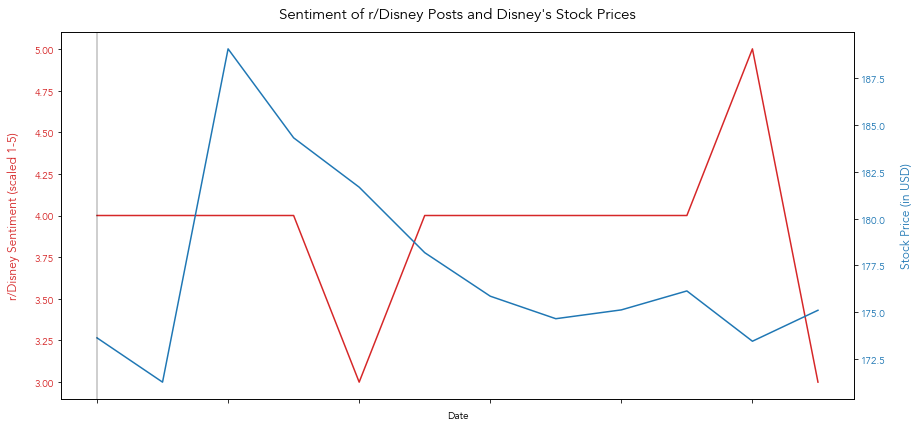

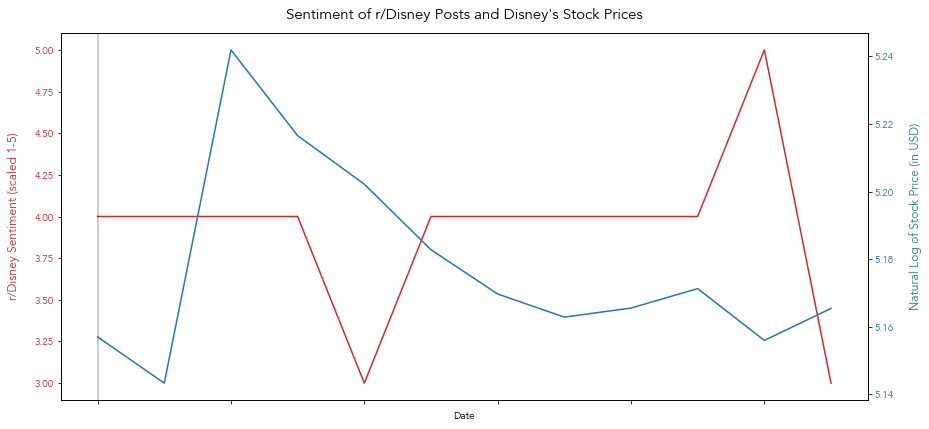

In [124]:
raw_reddit_comments_df = getRedditData('Disney', 'raw_disney_comments.csv', is_posts=False, content_limit=1000)
raw_finance_df = getFinanceData('DIS', 'raw_finance.csv', '2000-01-01', '2021-11-15')
cleaned_reddit_comments_df = cleanRedditComments('', 'cleaned_disney_comments.csv', raw_reddit_comments_df)
reddit_comments_and_sentiment_df = getSentiment('', 'disney_comments_w_sentiment.csv', False, cleaned_reddit_comments_df)
reddit_sentiment_df = getDateAndSentiment('disney_comments_w_sentiment.csv', 'disney_sentiment.csv')
graphable_sentiment, graphable_finance = getUsableData('', '', 'graphable_sentiment.csv', 'graphable_finance.csv', reddit_sentiment_df, raw_finance_df)
sentimentVsFinance('graphable_sentiment.csv', 'graphable_finance.csv', 'Sentiment of r/Disney Posts and Disney\'s Stock Prices')
smoothed_df = sentimentVsFinance('graphable_sentiment.csv', 'graphable_finance.csv', 'Sentiment of r/Disney Posts and Disney\'s Stock Prices', True)

#### Pre-Prepared Graphs

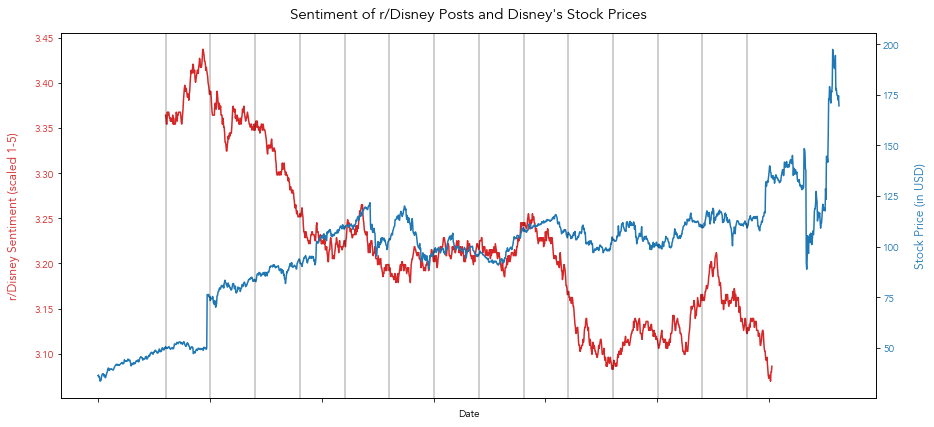

In [125]:
# Sentiments from Posts
smoothed_df = sentimentVsFinance('GRAPHABLE_POST_SENTIMENT.csv', 'POST_FINANCE.csv', 'Sentiment of r/Disney Posts and Disney\'s Stock Prices')

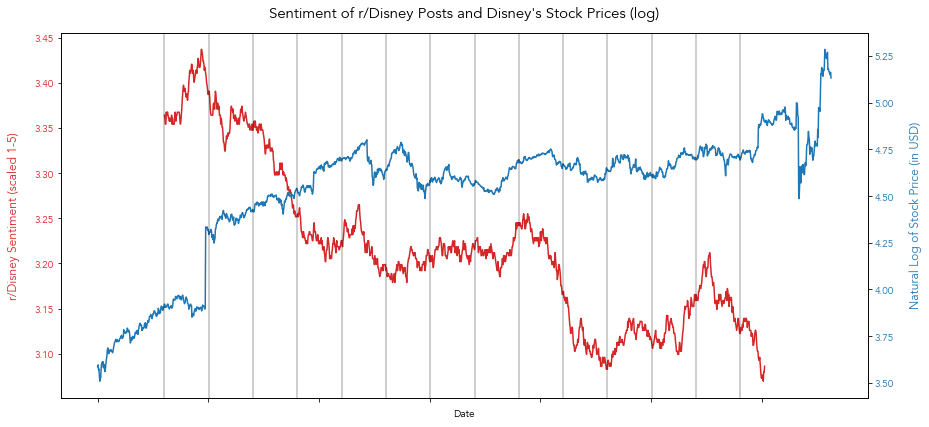

In [126]:
# Sentiments from Posts with Normalized Stock Prices
smoothed_df = sentimentVsFinance('GRAPHABLE_POST_SENTIMENT.csv', 'POST_FINANCE.csv', 'Sentiment of r/Disney Posts and Disney\'s Stock Prices (log)', True)

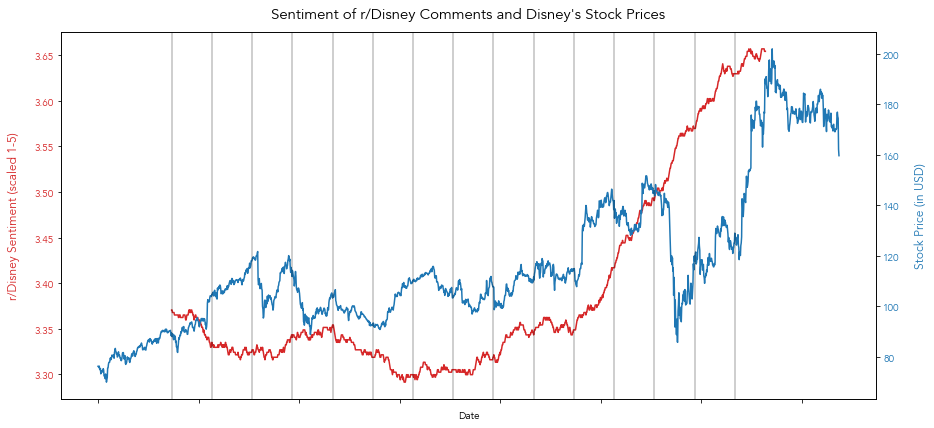

In [127]:
# Sentiments from Comments
smoothed_df = sentimentVsFinance('GRAPHABLE_COMMENT_SENTIMENT.csv', 'COMMENT_FINANCE.csv', 'Sentiment of r/Disney Comments and Disney\'s Stock Prices')

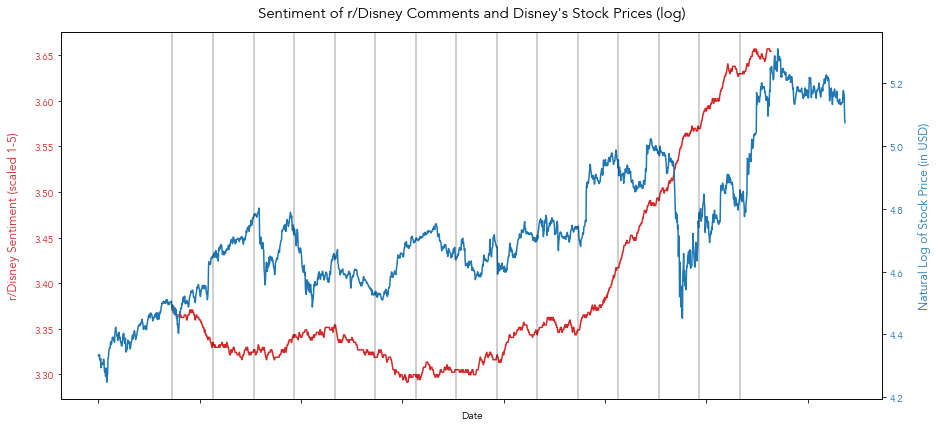

In [128]:
# Sentiments from Comments with Normalized Stock Prices
smoothed_df = sentimentVsFinance('GRAPHABLE_COMMENT_SENTIMENT.csv', 'COMMENT_FINANCE.csv', 'Sentiment of r/Disney Comments and Disney\'s Stock Prices (log)', True)

## Converting Sentiment & Stock Price Graphs to Plotly

In [129]:
graph_font = dict(
    family = 'Avenir',
    size = 24,
    
)

ps_df = pd.read_csv('sampleData/SMOOTHED_POST_SENTIMENT.csv')
ps = ps_df['Sentiment']
ps_dates = ps_df['Date']

pp_df = pd.read_csv('POST_FINANCE.csv')
pp_raw = pp_df['Close_Price']
# Take natural log
pp = np.log(pp_raw)
pp_dates = pp_df['Date']

post_sentiment_fig = make_subplots(specs=[[{"secondary_y": True}]])

post_sentiment_fig.add_trace(
    go.Scatter(
        x = ps_dates,
        y = ps,
        name = 'Post Sentiment',
    ),
    secondary_y = False
)

post_sentiment_fig.add_trace(
    go.Scatter(
        x = pp_dates,
        y = pp,
        name = 'Natural Log of Stock Price',
    ),
    secondary_y = True
)

post_sentiment_fig.update_layout(
    title_text = 'Post Sentiment & Stock Price vs. Time',
    xaxis_title = 'Date',
    title_x = 0.5,
    height = 850,
    yaxis_showgrid = False,
    font = graph_font,
)

post_sentiment_fig.update_yaxes(
    title_text='Sentiment (5 = Highest; 1 = Lowest)',
    tickformat = ".2f", showgrid = False,
    secondary_y=False,
)
post_sentiment_fig.update_yaxes(title_text='Natural Log of Stock Price (USD)', tickformat = ".1f", showgrid = False, secondary_y=True,)

save_graph(post_sentiment_fig, 'graphs/post_sentiment.txt')

cs_df = pd.read_csv('sampleData/SMOOTHED_COMMENT_SENTIMENT.csv')
cs = cs_df['Sentiment']
cs_dates = cs_df['Date']

cp_df = pd.read_csv('COMMENT_FINANCE.csv')
cp_raw = cp_df['Price']
# Take natural log
cp = np.log(cp_raw)
cp = np.round(cp, 2)
cp_dates = cp_df['Date']

comment_sentiment_fig = make_subplots(specs=[[{"secondary_y": True}]])

comment_sentiment_fig.add_trace(
    go.Scatter(
        x = cs_dates,
        y = cs,
        name = 'Comment Sentiment',
    ),
    secondary_y = False
)

comment_sentiment_fig.add_trace(
    go.Scatter(
        x = cp_dates,
        y = cp,
        name = 'Natural Log of Stock Price',
    ),
    secondary_y = True
)

comment_sentiment_fig.update_layout(
    title_text = 'Comment Sentiment & Stock Price vs. Time',
    xaxis_title = 'Date',
    title_x = 0.5,
    height = 850,
    yaxis_showgrid = False,
    font = graph_font,
)

comment_sentiment_fig.update_yaxes(title_text='Sentiment (5 = Highest; 1 = Lowest)', tickformat = ".2f", showgrid = False, secondary_y=False)
comment_sentiment_fig.update_yaxes(title_text='Natural Log of Stock Price (USD)', tickformat = ".1f", showgrid = False, secondary_y=True)

save_graph(comment_sentiment_fig, 'graphs/comment_sentiment.txt')

In [130]:
post_sentiment_fig.show()
comment_sentiment_fig.show()